# Unzip images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Outfit_Recommendation_Project/polyvore_outfits_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: content/polyvore_outfits/images/160143625.jpg  
 extracting: content/polyvore_outfits/images/8920616.jpg  
 extracting: content/polyvore_outfits/images/171178956.jpg  
 extracting: content/polyvore_outfits/images/105346473.jpg  
 extracting: content/polyvore_outfits/images/176603466.jpg  
 extracting: content/polyvore_outfits/images/145196917.jpg  
 extracting: content/polyvore_outfits/images/213539820.jpg  
 extracting: content/polyvore_outfits/images/213361747.jpg  
 extracting: content/polyvore_outfits/images/213024677.jpg  
 extracting: content/polyvore_outfits/images/148282226.jpg  
 extracting: content/polyvore_outfits/images/77142609.jpg  
 extracting: content/polyvore_outfits/images/166531631.jpg  
 extracting: content/polyvore_outfits/images/194237932.jpg  
 extracting: content/polyvore_outfits/images/204485689.jpg  
 extracting: content/polyvore_outfits/images/141815039.jpg  
 extracting: content/polyvore_outfits

# Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn import model_selection
import tqdm
import matplotlib.image as mpimg

What we are considering as the all-body outfits:
*   All-Body Outfits:

> 1. All-body
> 2. Shoes
> 3. Outerwear (optional)
> 4. Bags (optional)


### Blank Image to be added as Input(s) if the outfit does not have the optional items.

In [ ]:
z = tf.zeros(shape=(224,224,3), dtype=tf.int64)
img = z.numpy()
tf.keras.utils.save_img('/content/drive/MyDrive/Outfit_Recommendation_Project/blank_image.jpg', img, 'channels_last')

In [ ]:
tf.random.set_seed(42)

# Compatibility Train Data

In [ ]:
train_comp_df = pd.read_csv('/content/drive/MyDrive/Outfit_Recommendation_Project/AllBody_Outfits_Data/train_df.csv')
train_comp_df

,compatibility,outfit_sample
0,1,"['199244701_6','199244701_1','0','199244701_2']"
1,1,"['200742384_5','200742384_1','0','200742384_2']"
2,1,"['220340816_5','220340816_1','0','220340816_2']"
3,1,"['217183057_4','217183057_1','0','217183057_2']"
4,1,"['199287279_5','199287279_1','0','199287279_2']"
...,...,...
23021,0,"['221719315_5','219887726_1','0','203351828_2']"
23022,0,"['222516864_4','173244929_1','0','208172613_2']"
23023,0,"['218864675_6','218506324_1','0','221405016_1']"
23024,0,"['220595501_3','105184990_1','0','211494606_3']"


In [ ]:
train_comp_imgs_df = pd.read_csv('/content/drive/MyDrive/Outfit_Recommendation_Project/Data_CSV_Files/disjiont_train_outfits_images.csv')
train_comp_imgs_df

,outfits_images_id,outfits_images_path
0,199244701_1,/content/content/polyvore_outfits/images/13262...
1,199244701_2,/content/content/polyvore_outfits/images/15396...
2,199244701_3,/content/content/polyvore_outfits/images/17116...
3,199244701_4,/content/content/polyvore_outfits/images/16279...
4,199244701_5,/content/content/polyvore_outfits/images/17253...
...,...,...
85930,205613256_4,/content/content/polyvore_outfits/images/17596...
85931,205613256_5,/content/content/polyvore_outfits/images/16292...
85932,205613256_6,/content/content/polyvore_outfits/images/18060...
85933,225327855_1,/content/content/polyvore_outfits/images/18038...


In [ ]:
blank_item = {'outfits_images_id': '0', 'outfits_images_path': '/content/drive/MyDrive/Outfit_Recommendation_Project/blank_image.jpg'}

train_comp_imgs_df = train_comp_imgs_df.append(blank_item, ignore_index = True)

train_comp_imgs_df

<ipython-input-9-c16044f7355c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_comp_imgs_df = train_comp_imgs_df.append(blank_item, ignore_index = True)


,outfits_images_id,outfits_images_path
0,199244701_1,/content/content/polyvore_outfits/images/13262...
1,199244701_2,/content/content/polyvore_outfits/images/15396...
2,199244701_3,/content/content/polyvore_outfits/images/17116...
3,199244701_4,/content/content/polyvore_outfits/images/16279...
4,199244701_5,/content/content/polyvore_outfits/images/17253...
...,...,...
85931,205613256_5,/content/content/polyvore_outfits/images/16292...
85932,205613256_6,/content/content/polyvore_outfits/images/18060...
85933,225327855_1,/content/content/polyvore_outfits/images/18038...
85934,225327855_2,/content/content/polyvore_outfits/images/20191...


# Compatibility Test Data

In [ ]:
test_comp_df = pd.read_csv('/content/drive/MyDrive/Outfit_Recommendation_Project/AllBody_Outfits_Data/test_df.csv')
test_comp_df

,compatibility,outfit_sample
0,1,"['219905886_6','219905886_1','219905886_7','21..."
1,1,"['17682761_4','0','0','17682761_1']"
2,1,"['96522071_4','0','0','96522071_1']"
3,1,"['74477030_6','74477030_1','74477030_8','74477..."
4,1,"['196794889_6','196794889_1','0','196794889_2']"
...,...,...
9306,0,"['212556911_4','223797921_1','0','218903300_2']"
9307,0,"['139981254_5','85586321_1','0','25253122_2']"
9308,0,"['210583888_5','0','0','72403647_2']"
9309,0,"['153181442_2','0','0','126141821_1']"


In [ ]:
test_comp_imgs_df = pd.read_csv('/content/drive/MyDrive/Outfit_Recommendation_Project/Data_CSV_Files/disjiont_test_outfits_images.csv')
test_comp_imgs_df

,outfits_images_id,outfits_images_path
0,222049137_1,/content/content/polyvore_outfits/images/15940...
1,222049137_2,/content/content/polyvore_outfits/images/20081...
2,222049137_3,/content/content/polyvore_outfits/images/20888...
3,222049137_4,/content/content/polyvore_outfits/images/20889...
4,222049137_5,/content/content/polyvore_outfits/images/17683...
...,...,...
74257,42911078_7,/content/content/polyvore_outfits/images/39806...
74258,210601169_1,/content/content/polyvore_outfits/images/18912...
74259,210601169_2,/content/content/polyvore_outfits/images/18912...
74260,210601169_3,/content/content/polyvore_outfits/images/18912...


In [ ]:
test_comp_imgs_df = test_comp_imgs_df.append(blank_item, ignore_index = True)

test_comp_imgs_df

<ipython-input-12-aa78036d7bd7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_comp_imgs_df = test_comp_imgs_df.append(blank_item, ignore_index = True)


,outfits_images_id,outfits_images_path
0,222049137_1,/content/content/polyvore_outfits/images/15940...
1,222049137_2,/content/content/polyvore_outfits/images/20081...
2,222049137_3,/content/content/polyvore_outfits/images/20888...
3,222049137_4,/content/content/polyvore_outfits/images/20889...
4,222049137_5,/content/content/polyvore_outfits/images/17683...
...,...,...
74258,210601169_1,/content/content/polyvore_outfits/images/18912...
74259,210601169_2,/content/content/polyvore_outfits/images/18912...
74260,210601169_3,/content/content/polyvore_outfits/images/18912...
74261,210601169_4,/content/content/polyvore_outfits/images/18912...


# Prepare dataframes for Siamese Network

In [ ]:
def parse_sample(outfit_sample):
    '''
    outfit_sample: STRING
    returns list of items id
    '''
    outfit_sample = re.sub('[\[\]\s\']', '', outfit_sample)
    outfit_items = np.array(outfit_sample.split(','))
    return outfit_items

In [ ]:
def parse_outfit(outfit_items, training = False ):
    '''
    outfit_items: list of outfit items
    returns list of outfit items path
    '''
    if training:
        outfit_imgs_path = np.array([train_comp_imgs_df.query(f'outfits_images_id in {[item]}').outfits_images_path.to_numpy()[0] for item in outfit_items])

    else:
        outfit_imgs_path = np.array([test_comp_imgs_df.query(f'outfits_images_id in {[item]}').outfits_images_path.to_numpy()[0] for item in outfit_items])

    return outfit_imgs_path


In [ ]:
train_df = pd.DataFrame(columns=['all_body', 'bags', 'outerwear', 'shoes', 'compatibility'])
test_df = pd.DataFrame(columns=['all_body', 'bags', 'outerwear', 'shoes', 'compatibility'])

In [ ]:
def make_dataframe(outfit_sample, compatibility, training = False):
    outfit_items = parse_sample(outfit_sample)
    items_imgs_path = parse_outfit(outfit_items, training )
    img_columns = ['all_body','bags','outerwear','shoes']
    row_dict = dict(zip(img_columns, list(items_imgs_path)))
    row_dict['compatibility'] = compatibility
    if training:
        global train_df
        train_df = pd.DataFrame.append(train_df, row_dict, ignore_index=True)
    else:
        global test_df
        test_df = pd.DataFrame.append(test_df, row_dict, ignore_index=True)



In [ ]:
for i in tqdm.tqdm(np.arange(train_comp_df.shape[0])):
    compatibility, outfit_sample = train_comp_df.iloc[i]
    make_dataframe(outfit_sample, compatibility, training=True)
train_df

Streaming output truncated to the last 5000 lines.
<ipython-input-16-2437d324fa5a>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = pd.DataFrame.append(train_df, row_dict, ignore_index=True)
 89%|████████▉ | 20528/23026 [08:31<01:05, 38.40it/s]<ipython-input-16-2437d324fa5a>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = pd.DataFrame.append(train_df, row_dict, ignore_index=True)
<ipython-input-16-2437d324fa5a>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = pd.DataFrame.append(train_df, row_dict, ignore_index=True)
<ipython-input-16-2437d324fa5a>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_

,all_body,bags,outerwear,shoes,compatibility
0,/content/content/polyvore_outfits/images/17231...,/content/content/polyvore_outfits/images/13262...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/15396...,1
1,/content/content/polyvore_outfits/images/17248...,/content/content/polyvore_outfits/images/16271...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/17188...,1
2,/content/content/polyvore_outfits/images/19597...,/content/content/polyvore_outfits/images/19864...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20604...,1
3,/content/content/polyvore_outfits/images/19122...,/content/content/polyvore_outfits/images/19251...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/18731...,1
4,/content/content/polyvore_outfits/images/16980...,/content/content/polyvore_outfits/images/17309...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/17268...,1
...,...,...,...,...,...
23021,/content/content/polyvore_outfits/images/20916...,/content/content/polyvore_outfits/images/18177...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/17344...,0
23022,/content/content/polyvore_outfits/images/17241...,/content/content/polyvore_outfits/images/77371...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/14569...,0
23023,/content/content/polyvore_outfits/images/18894...,/content/content/polyvore_outfits/images/20373...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20713...,0
23024,/content/content/polyvore_outfits/images/19884...,/content/content/polyvore_outfits/images/61556...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/16423...,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23026 entries, 0 to 23025
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   all_body       23026 non-null  object
 1   bags           23026 non-null  object
 2   outerwear      23026 non-null  object
 3   shoes          23026 non-null  object
 4   compatibility  23026 non-null  object
dtypes: object(5)
memory usage: 899.6+ KB


In [ ]:
for i in tqdm.tqdm(np.arange(test_comp_df.shape[0])):
    compatibility, outfit_sample = test_comp_df.iloc[i]
    make_dataframe(outfit_sample, compatibility, training=False)
test_df

Streaming output truncated to the last 5000 lines.
<ipython-input-16-2437d324fa5a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = pd.DataFrame.append(test_df, row_dict, ignore_index=True)
<ipython-input-16-2437d324fa5a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = pd.DataFrame.append(test_df, row_dict, ignore_index=True)
<ipython-input-16-2437d324fa5a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = pd.DataFrame.append(test_df, row_dict, ignore_index=True)
 73%|███████▎  | 6815/9311 [02:31<00:52, 47.27it/s]<ipython-input-16-2437d324fa5a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = 

,all_body,bags,outerwear,shoes,compatibility
0,/content/content/polyvore_outfits/images/20610...,/content/content/polyvore_outfits/images/20302...,/content/content/polyvore_outfits/images/20610...,/content/content/polyvore_outfits/images/20452...,1
1,/content/content/polyvore_outfits/images/16847...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/16339...,1
2,/content/content/polyvore_outfits/images/90133...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/91124...,1
3,/content/content/polyvore_outfits/images/77240...,/content/content/polyvore_outfits/images/44214...,/content/content/polyvore_outfits/images/72853...,/content/content/polyvore_outfits/images/74617...,1
4,/content/content/polyvore_outfits/images/16448...,/content/content/polyvore_outfits/images/15356...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/14005...,1
...,...,...,...,...,...
9306,/content/content/polyvore_outfits/images/19049...,/content/content/polyvore_outfits/images/21304...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20317...,0
9307,/content/content/polyvore_outfits/images/11999...,/content/content/polyvore_outfits/images/78013...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/23328...,0
9308,/content/content/polyvore_outfits/images/18528...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/76389...,0
9309,/content/content/polyvore_outfits/images/13256...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/10817...,0


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9311 entries, 0 to 9310
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   all_body       9311 non-null   object
 1   bags           9311 non-null   object
 2   outerwear      9311 non-null   object
 3   shoes          9311 non-null   object
 4   compatibility  9311 non-null   object
dtypes: object(5)
memory usage: 363.8+ KB


###Change the position of the columns

In [ ]:
new_cols = ["all_body","shoes","outerwear","bags","compatibility"]
train_df=train_df[new_cols]
train_df

,all_body,shoes,outerwear,bags,compatibility
0,/content/content/polyvore_outfits/images/17231...,/content/content/polyvore_outfits/images/15396...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/13262...,1
1,/content/content/polyvore_outfits/images/17248...,/content/content/polyvore_outfits/images/17188...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/16271...,1
2,/content/content/polyvore_outfits/images/19597...,/content/content/polyvore_outfits/images/20604...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/19864...,1
3,/content/content/polyvore_outfits/images/19122...,/content/content/polyvore_outfits/images/18731...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/19251...,1
4,/content/content/polyvore_outfits/images/16980...,/content/content/polyvore_outfits/images/17268...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/17309...,1
...,...,...,...,...,...
23021,/content/content/polyvore_outfits/images/20916...,/content/content/polyvore_outfits/images/17344...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/18177...,0
23022,/content/content/polyvore_outfits/images/17241...,/content/content/polyvore_outfits/images/14569...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/77371...,0
23023,/content/content/polyvore_outfits/images/18894...,/content/content/polyvore_outfits/images/20713...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20373...,0
23024,/content/content/polyvore_outfits/images/19884...,/content/content/polyvore_outfits/images/16423...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/61556...,0


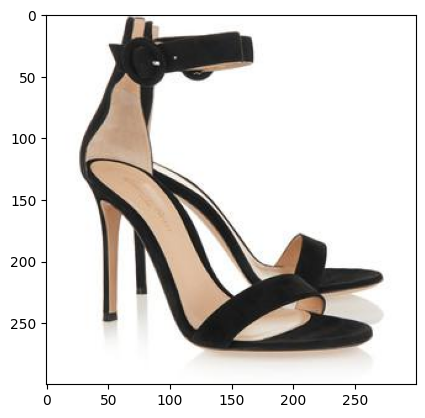

In [ ]:

img = mpimg.imread('/content/content/polyvore_outfits/images/153967122.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
test_df=test_df[new_cols]
test_df

,all_body,shoes,outerwear,bags,compatibility
0,/content/content/polyvore_outfits/images/20610...,/content/content/polyvore_outfits/images/20452...,/content/content/polyvore_outfits/images/20610...,/content/content/polyvore_outfits/images/20302...,1
1,/content/content/polyvore_outfits/images/16847...,/content/content/polyvore_outfits/images/16339...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,1
2,/content/content/polyvore_outfits/images/90133...,/content/content/polyvore_outfits/images/91124...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,1
3,/content/content/polyvore_outfits/images/77240...,/content/content/polyvore_outfits/images/74617...,/content/content/polyvore_outfits/images/72853...,/content/content/polyvore_outfits/images/44214...,1
4,/content/content/polyvore_outfits/images/16448...,/content/content/polyvore_outfits/images/14005...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/15356...,1
...,...,...,...,...,...
9306,/content/content/polyvore_outfits/images/19049...,/content/content/polyvore_outfits/images/20317...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/21304...,0
9307,/content/content/polyvore_outfits/images/11999...,/content/content/polyvore_outfits/images/23328...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/78013...,0
9308,/content/content/polyvore_outfits/images/18528...,/content/content/polyvore_outfits/images/76389...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,0
9309,/content/content/polyvore_outfits/images/13256...,/content/content/polyvore_outfits/images/10817...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,0


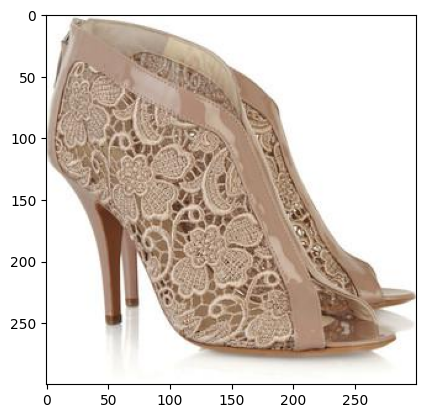

In [ ]:


img = mpimg.imread('/content/content/polyvore_outfits/images/16339902.jpg')
imgplot = plt.imshow(img)

plt.show()

combine predefined train and test data to split them having more train samples and less test samples.

In [ ]:
full_df = pd.DataFrame.append(train_df, test_df, ignore_index=True)
full_df.compatibility = full_df.compatibility.astype('int64')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32337 entries, 0 to 32336
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   all_body       32337 non-null  object
 1   shoes          32337 non-null  object
 2   outerwear      32337 non-null  object
 3   bags           32337 non-null  object
 4   compatibility  32337 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


<ipython-input-25-9082dfc0b4fd>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = pd.DataFrame.append(train_df, test_df, ignore_index=True)


## Split Train Test

In [ ]:
train, test = model_selection.train_test_split(full_df,
                                               test_size=0.1,
                                               random_state=42,
                                               stratify=full_df.compatibility
                                               )

In [ ]:
train

,all_body,shoes,outerwear,bags,compatibility
13621,/content/content/polyvore_outfits/images/21068...,/content/content/polyvore_outfits/images/21433...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,1
31085,/content/content/polyvore_outfits/images/19511...,/content/content/polyvore_outfits/images/21201...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/15890...,0
16862,/content/content/polyvore_outfits/images/21302...,/content/content/polyvore_outfits/images/20132...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/19212...,1
29954,/content/content/polyvore_outfits/images/10764...,/content/content/polyvore_outfits/images/12144...,/content/content/polyvore_outfits/images/14097...,/content/content/polyvore_outfits/images/19060...,0
7464,/content/content/polyvore_outfits/images/15974...,/content/content/polyvore_outfits/images/16600...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/17120...,0
...,...,...,...,...,...
7068,/content/content/polyvore_outfits/images/20303...,/content/content/polyvore_outfits/images/20586...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20867...,0
27776,/content/content/polyvore_outfits/images/14119...,/content/content/polyvore_outfits/images/16291...,/content/content/polyvore_outfits/images/98341...,/content/content/polyvore_outfits/images/13121...,0
2919,/content/content/polyvore_outfits/images/14043...,/content/content/polyvore_outfits/images/14199...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/14359...,1
11827,/content/content/polyvore_outfits/images/20001...,/content/content/polyvore_outfits/images/20629...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20380...,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29103 entries, 13621 to 31272
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   all_body       29103 non-null  object
 1   shoes          29103 non-null  object
 2   outerwear      29103 non-null  object
 3   bags           29103 non-null  object
 4   compatibility  29103 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


array([[<Axes: title={'center': 'compatibility'}>]], dtype=object)

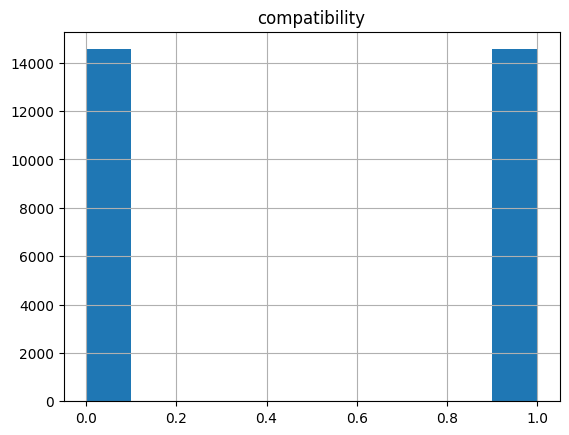

In [ ]:
train.hist()

In [ ]:
test

,all_body,shoes,outerwear,bags,compatibility
26341,/content/content/polyvore_outfits/images/81323...,/content/content/polyvore_outfits/images/79060...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/81691...,1
13335,/content/content/polyvore_outfits/images/20745...,/content/content/polyvore_outfits/images/20672...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/20520...,1
26161,/content/content/polyvore_outfits/images/12306...,/content/content/polyvore_outfits/images/10868...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/14070...,1
26912,/content/content/polyvore_outfits/images/19450...,/content/content/polyvore_outfits/images/18842...,/content/content/polyvore_outfits/images/19150...,/content/content/polyvore_outfits/images/20157...,1
12713,/content/content/polyvore_outfits/images/19195...,/content/content/polyvore_outfits/images/20462...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/21138...,1
...,...,...,...,...,...
13462,/content/content/polyvore_outfits/images/20238...,/content/content/polyvore_outfits/images/20888...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/drive/MyDrive/Outfit_Recommendation_P...,1
6122,/content/content/polyvore_outfits/images/21009...,/content/content/polyvore_outfits/images/12378...,/content/content/polyvore_outfits/images/12245...,/content/content/polyvore_outfits/images/19484...,0
17955,/content/content/polyvore_outfits/images/17702...,/content/content/polyvore_outfits/images/20261...,/content/drive/MyDrive/Outfit_Recommendation_P...,/content/content/polyvore_outfits/images/21317...,0
31878,/content/content/polyvore_outfits/images/17600...,/content/content/polyvore_outfits/images/13038...,/content/content/polyvore_outfits/images/61838...,/content/drive/MyDrive/Outfit_Recommendation_P...,0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3234 entries, 26341 to 29161
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   all_body       3234 non-null   object
 1   shoes          3234 non-null   object
 2   outerwear      3234 non-null   object
 3   bags           3234 non-null   object
 4   compatibility  3234 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 151.6+ KB


In [ ]:
test.hist()

# Save Siamese Model Data

In [ ]:
train.to_csv('/content/drive/MyDrive/Outfit_Recommendation_Project/AllBody_Outfits_Data/train4siamese.csv', index=False)
test.to_csv('/content/drive/MyDrive/Outfit_Recommendation_Project/AllBody_Outfits_Data/test4siamese.csv', index=False)

# Data Pipeline

In [ ]:
def read_image(x, y):
    img1, img2, img3, img4 = x

    img1 = tf.io.read_file(img1)
    img1 = tf.image.decode_jpeg(img1, channels=3)
    img1 = tf.image.convert_image_dtype(img1, tf.float32)
    img1 = tf.image.resize(img1, [224, 224])
    img1 = tf.clip_by_value(img1, clip_value_min=0, clip_value_max=1)

    img2 = tf.io.read_file(img2)
    img2 = tf.image.decode_jpeg(img2, channels=3)
    img2 = tf.image.convert_image_dtype(img2, tf.float32)
    img2 = tf.image.resize(img2, [224, 224])
    img2 = tf.clip_by_value(img2, clip_value_min=0, clip_value_max=1)

    img3 = tf.io.read_file(img3)
    img3 = tf.image.decode_jpeg(img3, channels=3)
    img3 = tf.image.convert_image_dtype(img3, tf.float32)
    img3 = tf.image.resize(img3, [224, 224])
    img3 = tf.clip_by_value(img3, clip_value_min=0, clip_value_max=1)

    img4 = tf.io.read_file(img4)
    img4 = tf.image.decode_jpeg(img4, channels=3)
    img4 = tf.image.convert_image_dtype(img4, tf.float32)
    img4 = tf.image.resize(img4, [224, 224])
    img4 = tf.clip_by_value(img4, clip_value_min=0, clip_value_max=1)



    return (img1, img2, img3, img4), y

In [ ]:
def augment_image(x, y):
    img1, img2, img3, img4 = x

    img1 = tf.image.random_flip_left_right(img1)
    img1 = tf.image.random_brightness(img1, max_delta=32.0 / 255.0)
    img1 = tf.image.random_saturation(img1, lower=0.5, upper=1.5)
    img1 = tf.clip_by_value(img1, 0.0, 1.0)

    img2 = tf.image.random_flip_left_right(img2)
    img2 = tf.image.random_brightness(img2, max_delta=32.0 / 255.0)
    img2 = tf.image.random_saturation(img2, lower=0.5, upper=1.5)
    img2 = tf.clip_by_value(img2, 0.0, 1.0)

    img3 = tf.image.random_flip_left_right(img3)
    img3 = tf.image.random_brightness(img3, max_delta=32.0 / 255.0)
    img3 = tf.image.random_saturation(img3, lower=0.5, upper=1.5)
    img3 = tf.clip_by_value(img3, 0.0, 1.0)

    img4 = tf.image.random_flip_left_right(img4)
    img4 = tf.image.random_brightness(img4, max_delta=32.0 / 255.0)
    img4 = tf.image.random_saturation(img4, lower=0.5, upper=1.5)
    img4 = tf.clip_by_value(img4, 0.0, 1.0)



    return (img1, img2, img3, img4), y


In [ ]:
train.all_body

13621    /content/content/polyvore_outfits/images/21068...
31085    /content/content/polyvore_outfits/images/19511...
16862    /content/content/polyvore_outfits/images/21302...
29954    /content/content/polyvore_outfits/images/10764...
7464     /content/content/polyvore_outfits/images/15974...
                               ...                        
7068     /content/content/polyvore_outfits/images/20303...
27776    /content/content/polyvore_outfits/images/14119...
2919     /content/content/polyvore_outfits/images/14043...
11827    /content/content/polyvore_outfits/images/20001...
31272    /content/content/polyvore_outfits/images/10765...
Name: all_body, Length: 29103, dtype: object

In [ ]:
test.compatibility

26341    1
13335    1
26161    1
26912    1
12713    1
        ..
13462    1
6122     0
17955    0
31878    0
29161    0
Name: compatibility, Length: 3234, dtype: int64

In [ ]:
def dataset_creater(x1, x2, x3, x4, y, training=False):
    data = tf.data.Dataset.from_tensor_slices(((x1, x2, x3, x4), y))

    data = data.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        data = data.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    data = data.shuffle(1028)
    data = data.batch(32, drop_remainder=True)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data


train_dataset = dataset_creater(train.all_body, train.shoes,
                                train.outerwear, train.bags,
                                train.compatibility, training=True)

test_dataset = dataset_creater(test.all_body, test.shoes,
                                test.outerwear, test.bags, test.compatibility)

# Show Oufit Samples

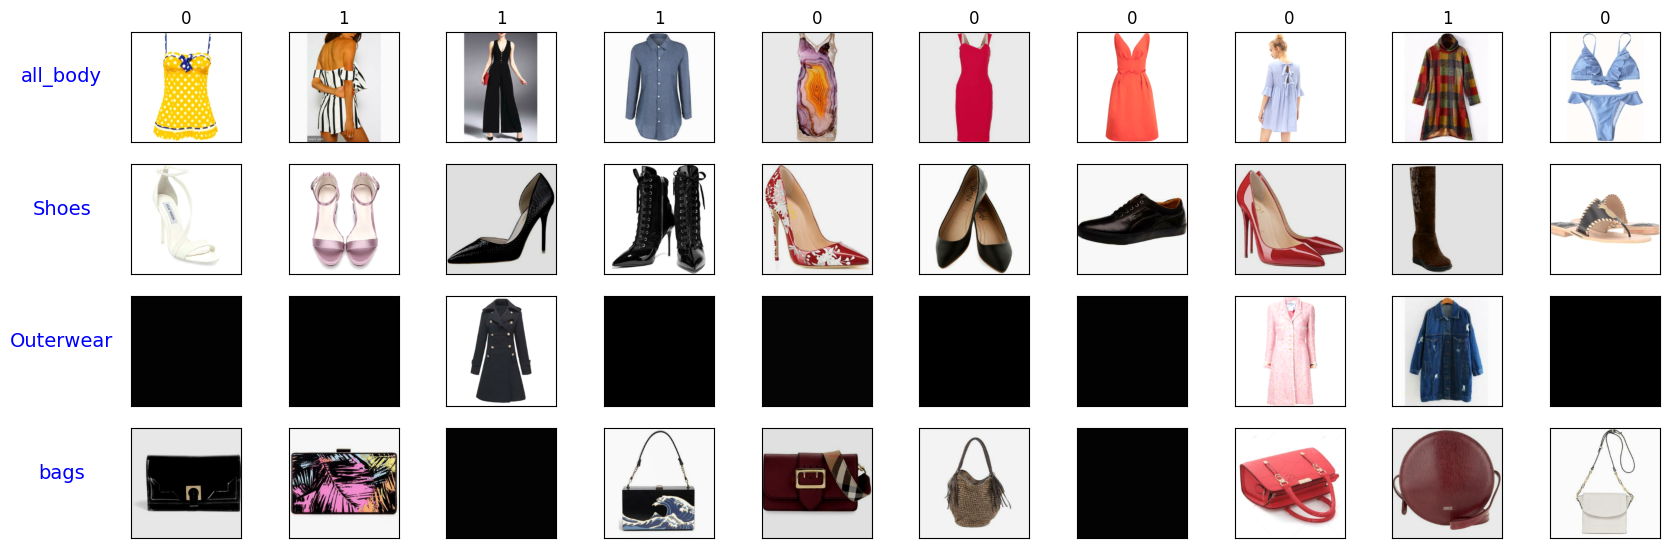

In [ ]:
n = 10
plt.figure(figsize=(20, 10))

for x, y in train_dataset.take(1):
    x1, x2, x3, x4 = x

    for i in range(n):

        plt.subplot(6, n, i + 1)
        plt.title(f"{y[i]}")
        plt.imshow(tf.squeeze(x1[i]))
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.ylabel('all_body', labelpad=50, rotation=0, fontsize=14, color='b')

        plt.subplot(6, n, n + i + 1)
        plt.imshow(tf.squeeze(x2[i]))
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.ylabel('Shoes', labelpad=50, rotation=0, fontsize=14, color='b')

        plt.subplot(6, n, 2*n + i + 1)
        plt.imshow(tf.squeeze(x3[i]))
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.ylabel('Outerwear', labelpad=50, rotation=0, fontsize=14, color='b')

        plt.subplot(6, n, 3*n + i + 1)
        plt.imshow(tf.squeeze(x4[i]))
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.ylabel('bags', labelpad=50, rotation=0, fontsize=14, color='b')



plt.show()

# Pretrained CNN Model

In [ ]:
cnn_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(224, 224, 3))
cnn_model.trainable = False
cnn_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

#Create the Siamese Model


In [ ]:
tf.keras.backend.clear_session()
class SiameseModel(tf.keras.Model):
    def __init__(self, cnn_model):
        super(SiameseModel, self).__init__()

        self.cnn_model = cnn_model

        # self.D1 = tf.keras.layers.GRU(units=512, return_sequences= True)
        # self.BN_1 = tf.keras.layers.BatchNormalization()
        # self.D2 = tf.keras.layers.GRU(units=128, return_sequences= False)
        # self.BN_2 = tf.keras.layers.BatchNormalization()

        self.D1 = tf.keras.layers.Dense(32, use_bias=False)
        self.BN_1 = tf.keras.layers.BatchNormalization()
        self.D2 = tf.keras.layers.Dense(128, use_bias=False)
        self.BN_2 = tf.keras.layers.BatchNormalization()




        self.out = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)

    def call(self, inputs):
        x1, x2, x3, x4= inputs

        x1 = self.cnn_model(x1)
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)

        x2 = self.cnn_model(x2)
        x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

        x3 = self.cnn_model(x3)
        x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)

        x4 = self.cnn_model(x4)
        x4 = tf.keras.layers.GlobalAveragePooling2D()(x4)

        x = tf.keras.layers.concatenate([x1, x2, x3, x4])
        # x = tf.reshape(x, (-1,x.shape[1], 1))
        x = self.D1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)
        x = self.D2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)

        out = self.out(x)

        return out

    def build_model(self, dim=[224, 224, 3]):
        x = (tf.keras.layers.Input(dim, name='all_body'),
             tf.keras.layers.Input(dim, name='shoes'), tf.keras.layers.Input(dim, name='outerwear'),
             tf.keras.layers.Input(dim, name='bags'))
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


model = SiameseModel(cnn_model=cnn_model)
model.build_model(dim=[224, 224, 3]).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 all_body (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 shoes (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 outerwear (InputLayer)      [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 bags (InputLayer)           [(None, 224, 224, 3)]        0         []                            
                                                                                              

In [ ]:
# build the model
x = (tf.keras.layers.Input([224, 224, 3], name='all_body'),
     tf.keras.layers.Input([224, 224, 3], name='shoes'), tf.keras.layers.Input([224, 224, 3], name='outerwear'),
     tf.keras.layers.Input([224, 224, 3], name='bags'))
model(x)
model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dense (Dense)               (None, 32)                131072    
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               4096      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1)               

##Plot the model

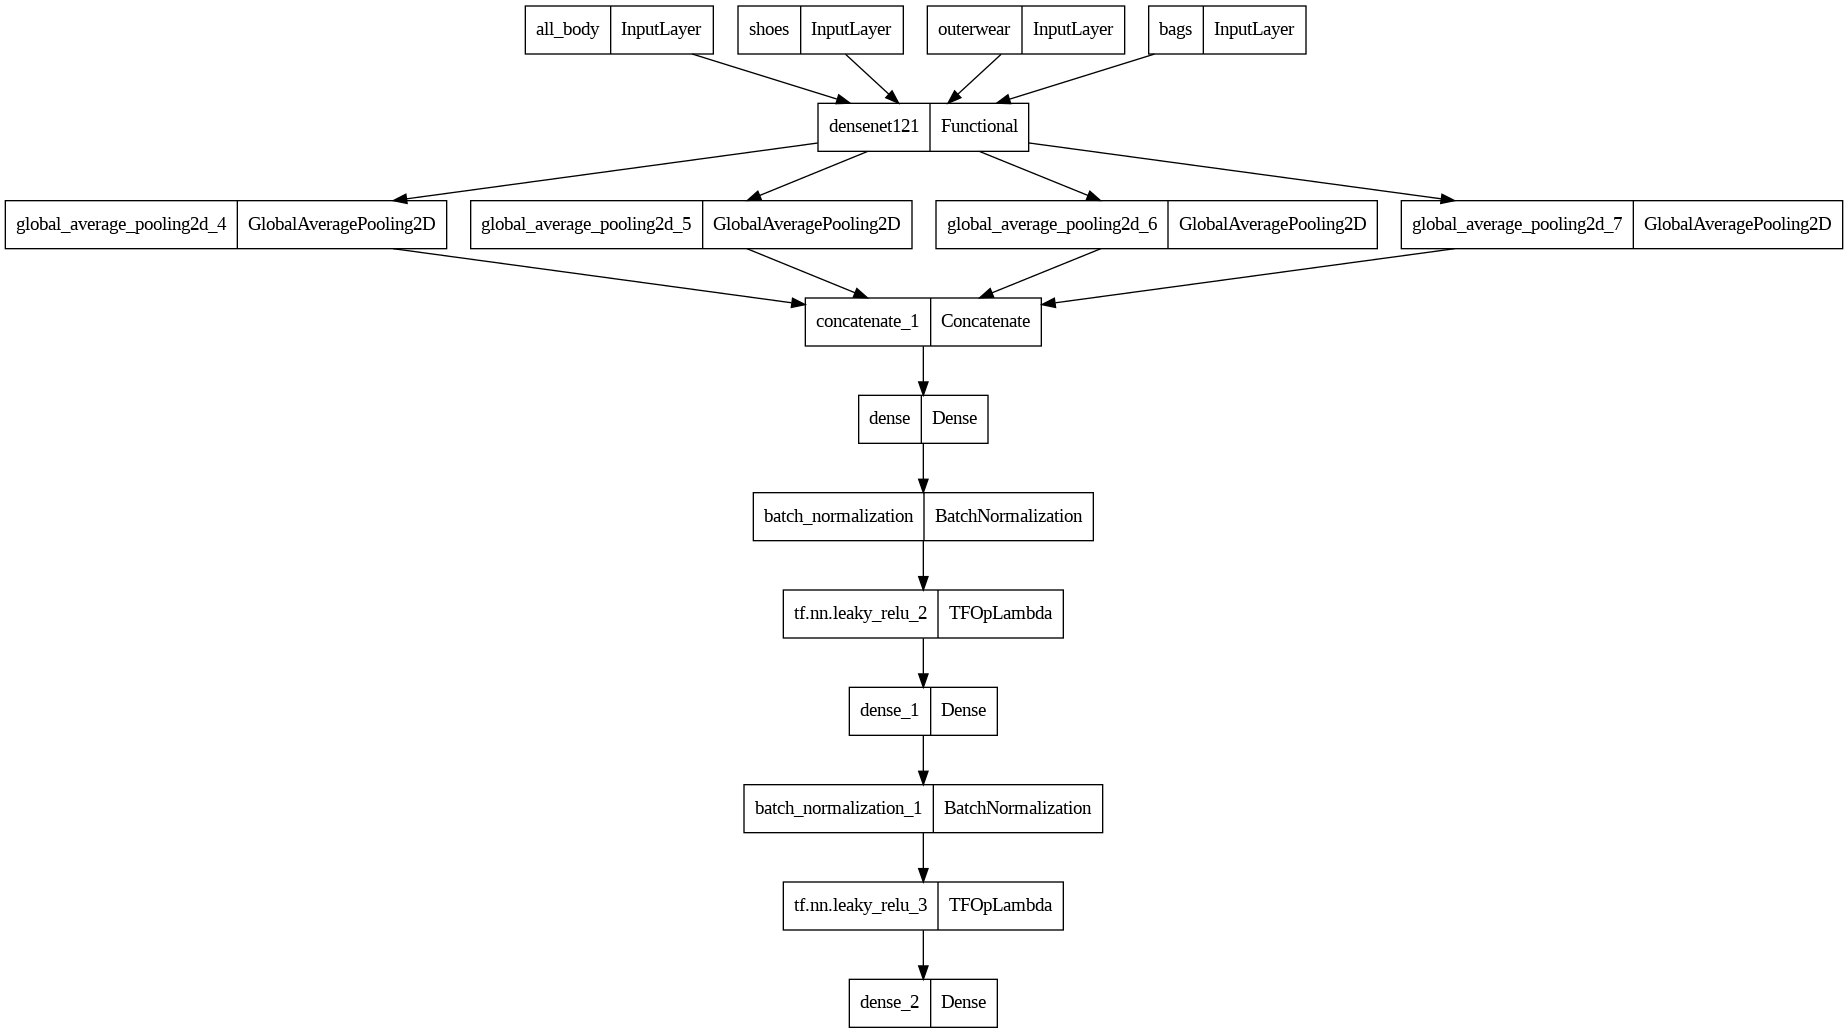

In [ ]:
tf.keras.utils.plot_model(model.build_model(dim=[224, 224, 3]))

##Define the Loss function and the optimizer

In [ ]:
loss_object = tf.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam()

# Train the model

In [ ]:
model.compile(optimizer=optimizer, loss=loss_object, metrics=["acc"])

In [ ]:
best_model = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Outfit_Recommendation_Project/best_model_4_all-body_outfits_lstm',
                                                monitor='val_loss',
                                                save_best_only=True
                                                )
model.fit(train_dataset, epochs=3, validation_data=test_dataset, callbacks= [best_model])

Epoch 1/3
909/909 [==============================] - ETA: 0s - loss: 0.6681 - acc: 0.5920

909/909 [==============================] - 512s 514ms/step - loss: 0.6681 - acc: 0.5920 - val_loss: 0.6428 - val_acc: 0.6182
Epoch 2/3
876/909 [===========================>..] - ETA: 13s - loss: 0.5922 - acc: 0.6816